This notebook is a summary of Novel session clustering control. I use the same steps as in original clustering analysis to examine clusters in the data from 3 Familiar sessions only in cells that were matched across at least 3 matched sessions. 

Two interesting questions that we can answer by looking at these clusters:
* What happens to the encoding scores after Novelty wears off?
* What are the rates of represetional drift across Novel sessions in three cre lines?

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [2]:
import visual_behavior.data_access.utilities as utilities
from visual_behavior.data_access import loading as loading
import visual_behavior.dimensionality_reduction.clustering as vba_clust

In [3]:
import visual_behavior_glm.GLM_params as glm_params
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_fit_dev as glm_fit

In [4]:
import visual_behavior.visualization.utils as utils
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering as ac

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [31]:
glm_version = '24_events_all_L2_optimize_by_session'
model_output_type = 'adj_fraction_change_from_full'

base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'
base_dir = os.path.join(base_dir, glm_version)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    
folder = '221018_novel_control'
save_dir = os.path.join(base_dir, folder)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    

In [8]:
dropout_features = ['all-images', 'omissions', 'behavioral', 'task']

## Load GLM results and select familiar sessions only

In [9]:
cells_table = loading.get_cell_table(platform_paper_only=True, limit_to_closest_active=False, limit_to_matched_cells=False, add_extra_columns=True)
print(len(cells_table.ophys_experiment_id.unique()), 'expts in cells table')
print(len(cells_table.cell_specimen_id.unique()), 'unique cell_specimen_ids in cells table')

1248 expts in cells table
28806 unique cell_specimen_ids in cells table


In [28]:
filename = os.path.join(save_dir, 'feature_matrix_novel_only.h5')
if os.path.exists(filename):
    feature_matrix = pd.read_hdf(filename, key = 'df')
    print('loaded feature matrix...')
# load and reshape file
else:
    run_params, results, results_pivoted, weights_df = glm_fit.get_analysis_dfs(glm_version)
    # select correct sessions
    active_only = results_pivoted[results_pivoted.session_type.isin(['OPHYS_4_images_B','OPHYS_6_images_B','OPHYS_4_images_A','OPHYS_6_images_A'])]
    # count how many cells have >= 3 sessions
    tmp = active_only.groupby('cell_specimen_id').count()[['session_type']]
    matched_cell_ids = tmp[tmp['session_type']>=3].index.values
    print('found {} cells...'.format(len(matched_cell_ids)))
    
    # drop cells that do not have at least 3 imaging sessions
    selected_sessions = active_only[active_only.cell_specimen_id.isin(matched_cell_ids)]
    # sort by date of imaging
    selected_sessions = selected_sessions.sort_values('date_of_acquisition')
    
    # rename session numbers to be sequential. Since there shouldnt be any difference among the sessions, we can just enumerate them.
    # I'm not going to create another column for this, since we already have "session_number" column. I will just replace those values
    for cid in matched_cell_ids:
        tmp = selected_sessions[selected_sessions.cell_specimen_id == cid]
        count = 1
        for index in tmp.index.values:
            selected_sessions.at[index, 'session_number'] = count
            count =count+1
    
    # group by cell id and session number
    feature_matrix = selected_sessions.groupby(['cell_specimen_id', 'session_number']).sum()[dropout_features].unstack()
    # drop cells with nan
    feature_matrix = feature_matrix.dropna(axis=1)
    
    # save
    feature_matrix.to_hdf(filename, key = 'df')

loaded feature matrix...


In [11]:
len(np.unique(feature_matrix.index.values))

1215

In [12]:
cre_lines = np.sort(cells_table.cre_line.unique())
cells_table_sel = cells_table[cells_table.cell_specimen_id.isin(feature_matrix.index.values)]

In [13]:
# separate feature matrix by cre line
cre_line_dfs = {}
for cre_line in cre_lines:
    cids = np.unique(cells_table_sel[cells_table_sel['cre_line']==cre_line]['cell_specimen_id'].values)
    print(cre_line,len(cids))
    df_cre = feature_matrix.loc[cids].copy()
    cre_line_dfs[cre_line] = df_cre

Slc17a7-IRES2-Cre 940
Sst-IRES-Cre 111
Vip-IRES-Cre 164


## Find optimal number of clusters

### Compute eigen gap

Optimal number of clusters [  1   2   3   5   6   7   8   4   9  10  15  16  14  13  11  17  20 939
  19 938  12  18  22  28  32]
Optimal number of clusters [  1   2   4   6   3 110   5   8   7  10  12 102  96   9  95  11  18 109
  15  13  16  17  99 101  97]
Optimal number of clusters [  1   2   4   3   6   5   9   8   7  12 163  11  13  18  16  15  25  19
  20 161 159  10 157  22  14]


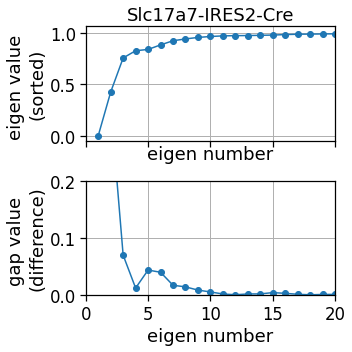

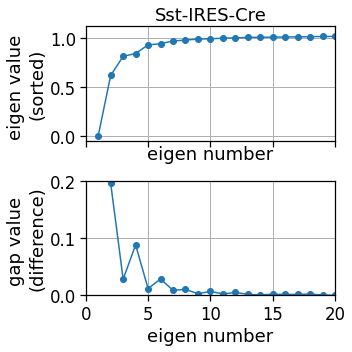

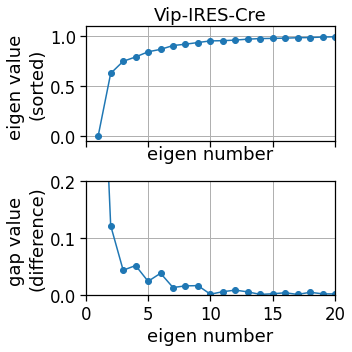

In [19]:
from sklearn.cluster import SpectralClustering

eigenGap_df = {}
for i, cre_line in enumerate(cre_lines):
    X = cre_line_dfs[cre_line].values
    sc = SpectralClustering()
    sc.fit(X)
    A = sc.affinity_matrix_
    
    eigenvalues, eigenvectors, nb_clusters = vba_clust.get_eigenDecomposition(A)
    
    fig, ax = plt.subplots(2,1, figsize = (5,5), sharex=True)
    ax[0].plot(np.arange(1,len(eigenvalues)+1), eigenvalues, '-o')
    ax[0].grid()
    ax[0].set_title(cre_line)
    ax[0].set_ylabel('eigen value \n(sorted)')
    ax[0].set_xlabel('eigen number')
    ax[0].set_xlim([0, 20])
    #ax[0].set_xticks([np.arange(2,20,step = 2)])
    
    ax[1].plot(np.arange(1,len(eigenvalues)), np.diff(eigenvalues), '-o')
    ax[1].set_ylabel('gap value \n(difference)')
    ax[1].set_xlabel('eigen number')
    ax[1].set_xlim([0, 20])
    ax[1].set_ylim([0, 0.20])
    ax[1].grid()
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, f'eigenGap_{cre_line}.png'))
    eigenGap_df[cre_line] = [ eigenvalues, eigenvectors, nb_clusters]
    print(f'Optimal number of clusters {nb_clusters}')
        
    

### Compute Gap statistic

In [32]:
import pickle

metric = 'euclidean' # default distance metric
shuffle_type ='all' # default shuffle type is all shuffle (cell id and regressors

gap_filename = os.path.join(save_dir, 'gap_scores_{}_{}_nb20_unshuffled_to_{}.pkl'.format(metric, glm_version, shuffle_type))
if os.path.exists(gap_filename):
    with open(gap_filename, 'rb') as f:
        gap_df = pickle.load(f)
        print('loaded file')
else:
    gap_df = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line]
        sc = SpectralClustering()
        gap_statistics = vba_clust.compute_gap(sc, X, k_max = 25)
        gap_df[cre_line]= gap_statistics
    vba_clust.save_clustering_results(gap_df, gap_filename)

shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling all data
shuffling al

In [45]:
gap_df[cre_line].keys()

dict_keys(['gap', 'reference_inertia', 'ondata_inertia', 'reference_sem', 'ondata_sem', 'gap_mean', 'gap_sem'])

In [ ]:
# plot gap statistic

for cre_line in cre_lines:
    fig, ax = plt.subplots(1,2, figsize = (10,3))
    x = len(gap_df[cre_line]['gap'])
    ax[0].plot(np.arange(2,x+2), gap_df[cre_line]['gap'], 'o-')
    ax[0].set_ylabel('gap value')
    ax[0].grid()
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line]['reference_inertia'], 'o-')
    ax[1].plot(np.arange(2,x+2),gap_df[cre_line]['ondata_inertia'], 'o-')
    ax[1].legend(['shuffled/reference', 'data'])
    ax[1].grid()
    plt.suptitle(cre_line + ' ' + metric + ' ' + shuffle_type)
    fig.savefig(os.path.join(save_dir, 'Gap_nb20_{}_{}_unshuffled_to_{}.png'.format(cre_line, metric, shuffle_type)))


**Discussion**: From examining the plots above, it seems like the original number of clusters: 10, 5, 10 for threee cre lines may not the the most optimal. We can first cluster familiar sessions with ogiinal number of N for easy comparison and then cluster with a different more optimal number.

## Cluster the data, 10 - 5 - 10

### Compute coclustering matrix

In [21]:
n_clusters_cre = [10,5,10]

In [22]:
filename = os.path.join(save_dir, 'coClustering_matrix.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pickle.load(f)
        f.close()
        print('done.')
else:
    n_clusters_cre = [10,5,10] # these n clusters are based on old sil plots
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line].values
        m = vba_clust.get_coClust_matrix(X=X,n_clusters=n_clusters_cre[i], nboot=np.arange(50))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.55it/s]


#### Assign labels based on agglomerative clustering

In [23]:
labels_cre={}
for i,cre_line in enumerate(cre_lines):
    X = coclustering_matrices[cre_line]
    cluster = ac(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    labels_cre[cre_line] = cluster.fit_predict(X)

#### Plot Coclustering matrix

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


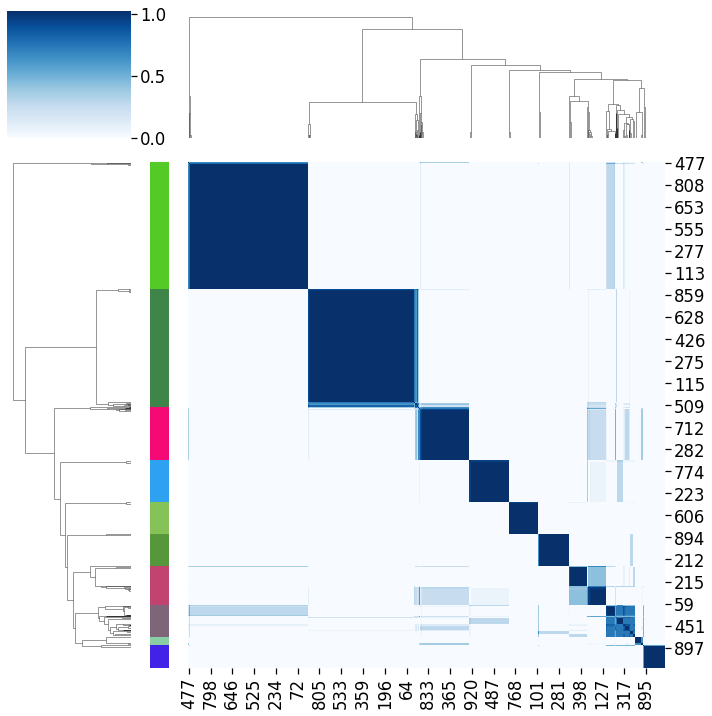

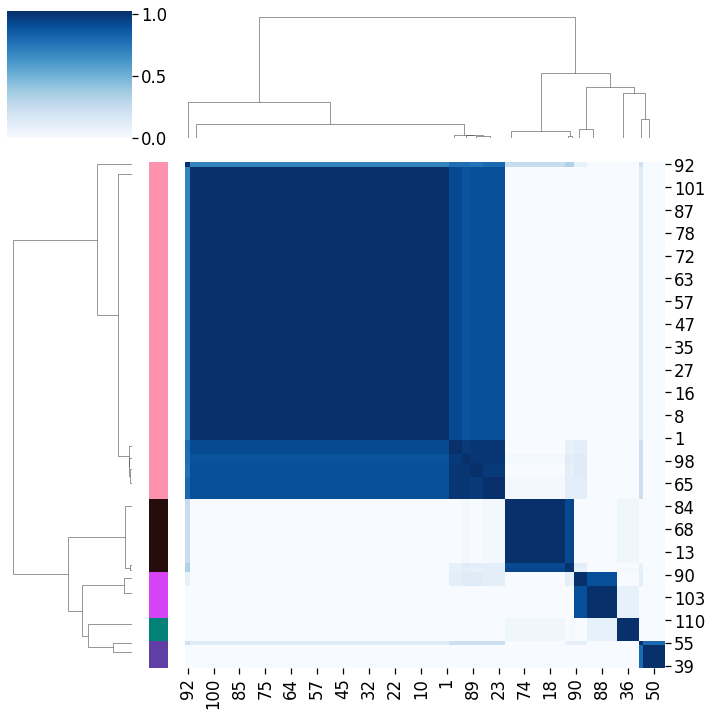

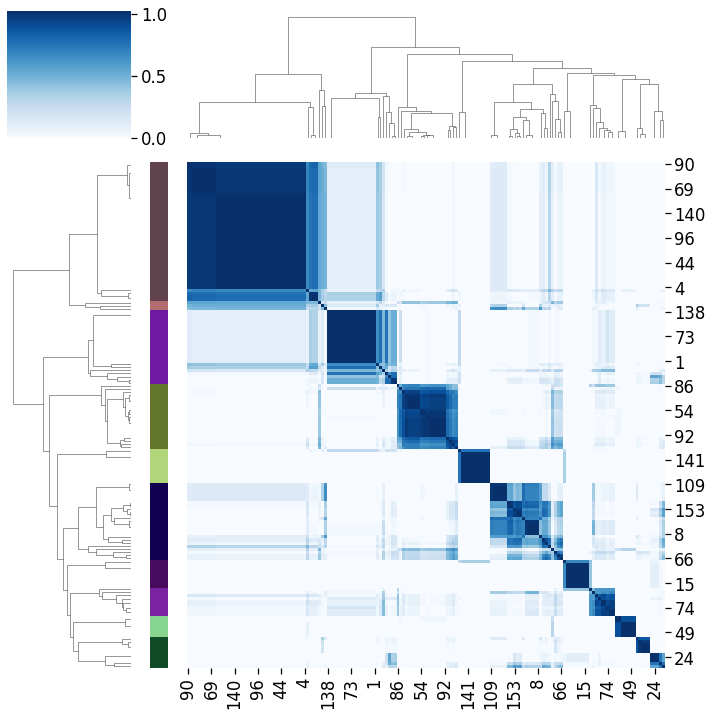

In [24]:
for i, cre_line in enumerate(cre_lines):
    labels = labels_cre[cre_line] 
    row_colors = vba_clust.get_cluster_colors(labels)
    fig = sns.clustermap(coclustering_matrices[cre_line], cmap = 'Blues', row_colors = row_colors)
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, 'Clustermap_{}_{}_nc{}.png'.format(cre_line, 
                                                                    glm_version,
                                                                    n_clusters_cre[i])))
    

### Plot cluster dropout scores

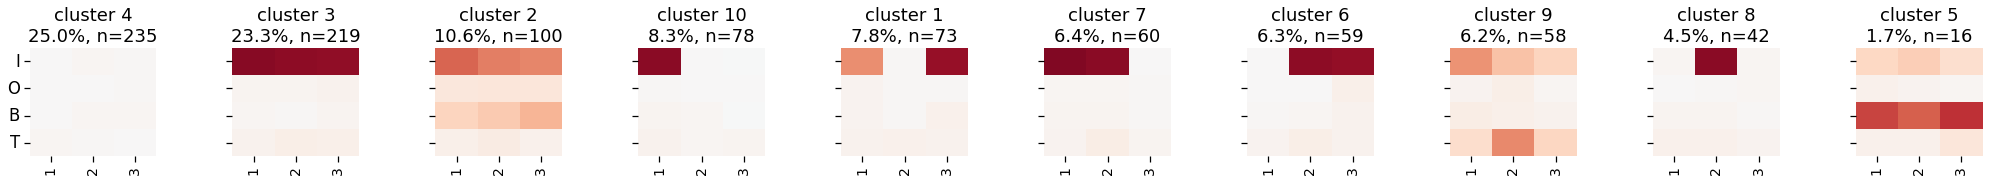

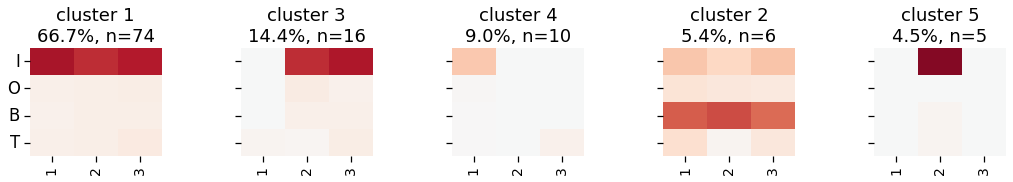

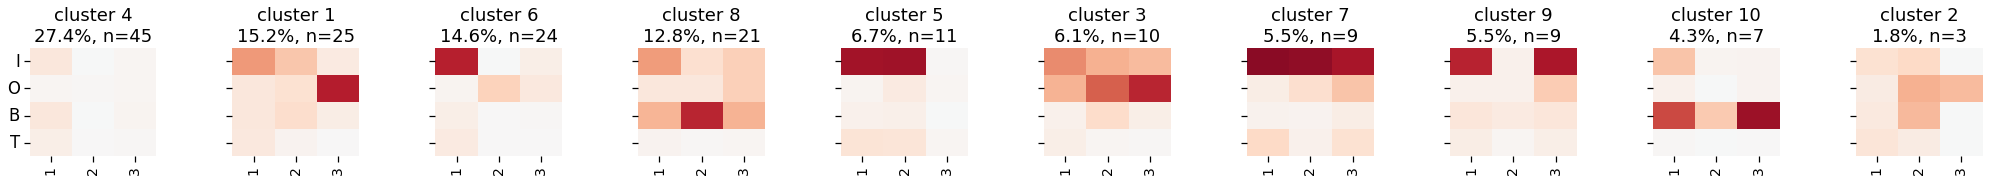

In [25]:

sort_order = {}
for i, cre_line in enumerate(cre_lines):
    tmp = cre_line_dfs[cre_line]
    labels = labels_cre[cre_line] 
    cluster_df = pd.DataFrame(index = tmp.index.values, columns = ['cluster_id', 'cre_line'], 
                              data = np.transpose([labels+1, [cre_line]* len(labels)]))
    #cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, tmp, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='', suffix=f'_familiar_only_{n_clusters_cre}',
                                 abbreviate_experience=False)


### Plot area and depth analysis

In [26]:
## add cluster id
cells_table_sel = cells_table_sel.drop_duplicates('cell_specimen_id')
cells_table_sel = cells_table_sel.set_index('cell_specimen_id')
df_meta = cells_table_sel.copy()
for cre_line in cre_lines:
    labels = labels_cre[cre_line] 
    index = cre_line_dfs[cre_line].index.values
    df_meta.at[index, 'cluster_id'] = labels+1
    
    


In [29]:
# this plot doesnt work without multi_session_df

for cre_line in cre_lines:
    vba_clust.plot_clusters_stats_pop_avg_rows(df_meta, feature_matrix, multi_session_df=None, cre_line = cre_line,
                                     columns_to_groupby=['targeted_structure'], change=False, omitted=True,
                                     sort_order=None, save_dir=save_dir, folder='areas', suffix='', alpha=None)


AttributeError: 'NoneType' object has no attribute 'merge'

## Cluster the data, 8 - 4 - 11

### Compute coclustering matrix

In [121]:
n_clusters_cre = [8,4,11]

In [122]:
filename = os.path.join(save_dir, f'coClustering_matrix_{n_clusters_cre}.pkl')
if os.path.exists(filename):
    print('loading file...')
    with open(filename, 'rb') as f:
        coclustering_matrices  = pickle.load(f)
        f.close()
        print('done.')
else:
    coclustering_matrices = {}
    for i, cre_line in enumerate(cre_lines):
        X = cre_line_dfs[cre_line].values
        print(n_clusters_cre[i])
        m = vba_clust.get_coClust_matrix(X=X,n_clusters=n_clusters_cre[i], nboot=np.arange(50))
        coclustering_matrices[cre_line]=m
    vba_clust.save_clustering_results(coclustering_matrices, filename)

8


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.38it/s]


4


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 28.53it/s]


11


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 16.65it/s]


#### Assign labels based on agglomerative clustering

In [123]:
labels_cre={}
for i,cre_line in enumerate(cre_lines):
    X = coclustering_matrices[cre_line]
    print(n_clusters_cre[i])
    cluster = ac(n_clusters=n_clusters_cre[i], affinity='euclidean', linkage='average')
    labels_cre[cre_line] = cluster.fit_predict(X)

8
4
11


#### Plot Coclustering matrix

C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


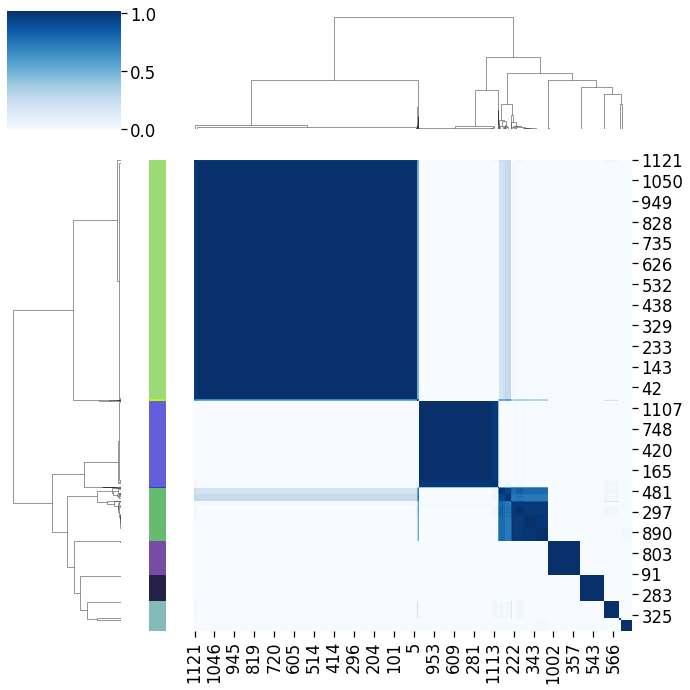

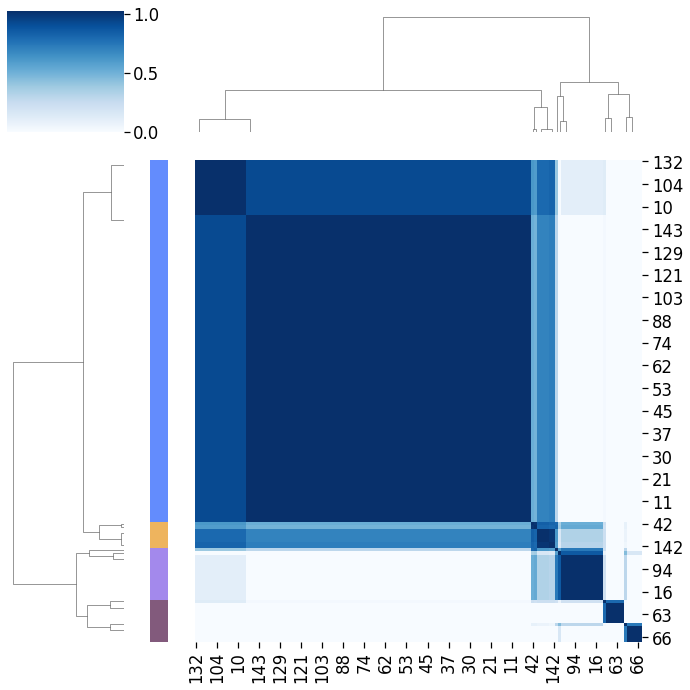

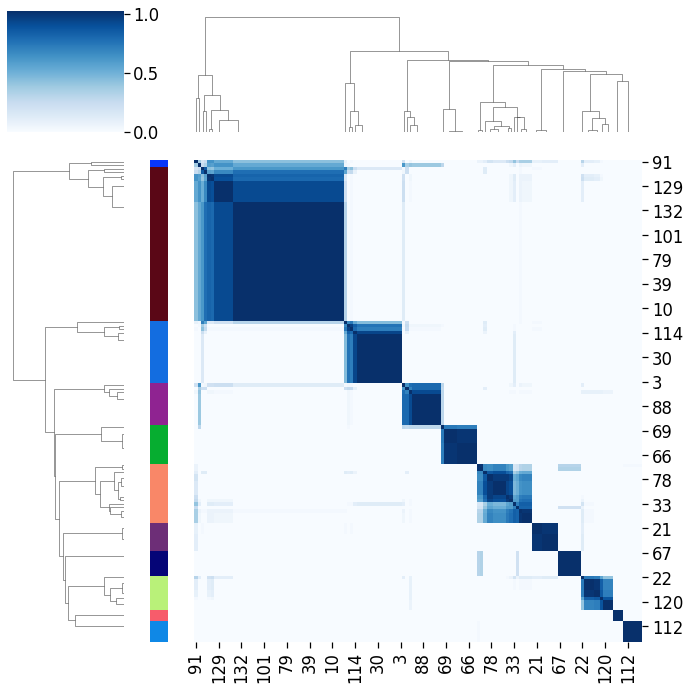

In [124]:
for i, cre_line in enumerate(cre_lines):
    labels = labels_cre[cre_line] 
    row_colors = vba_clust.get_cluster_colors(labels)
    fig = sns.clustermap(coclustering_matrices[cre_line], cmap = 'Blues', row_colors = row_colors)
    plt.tight_layout()
    fig.savefig(os.path.join(save_dir, 'Clustermap_{}_{}_nc{}.png'.format(cre_line, 
                                                                    glm_version,
                                                                    n_clusters_cre[i])))
    

### Plot cluster dropout scores

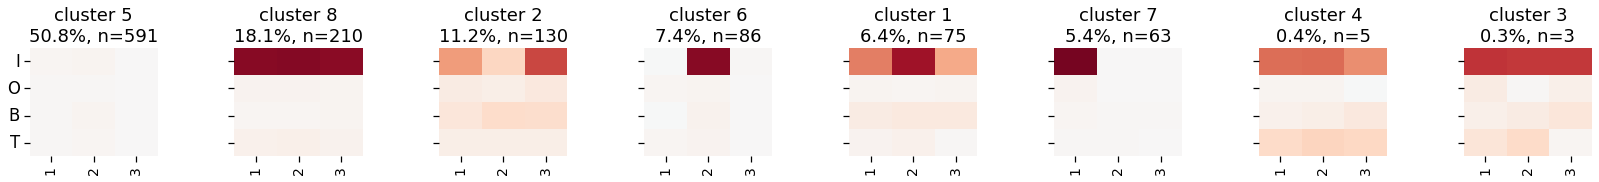

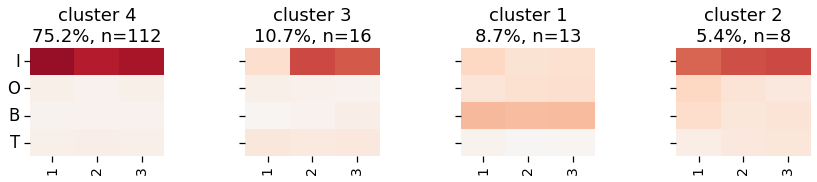

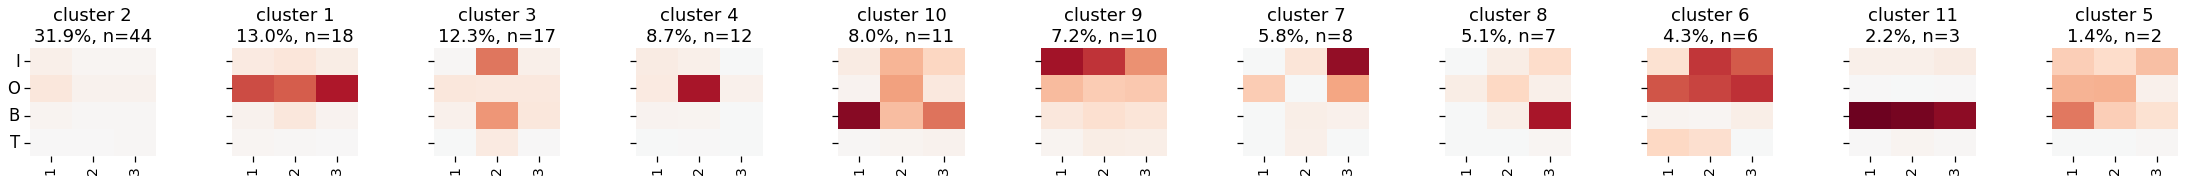

In [125]:

sort_order = {}
for cre_line in cre_lines:
    feature_matrix = cre_line_dfs[cre_line]
    labels = labels_cre[cre_line] 
    cluster_df = pd.DataFrame(index = feature_matrix.index.values, columns = ['cluster_id', 'cre_line'], 
                              data = np.transpose([labels+1, [cre_line]* len(labels)]))
    #cluster_df = original_cluster_labels[original_cluster_labels.cre_line == cre_line].set_index('cell_specimen_id')
    sort_order[cre_line] = vba_clust.get_sorted_cluster_ids(cluster_df)
    vba_clust.plot_clusters_row(cluster_df, feature_matrix, cre_line,
                               sort_order=sort_order, save_dir=save_dir, folder='test', suffix='_familiar_only',
                                 abbreviate_experience=False)


## Comapring clusters in Familiar and Original data

In [ ]:
Compare size of matched clusters
Find the same cells and see where they move to (which cluster)

## Summary